In [5]:
import pandas as pd
from matplotlib.ticker import FuncFormatter
from Cohort import CohortTable


In [3]:
myTable = CohortTable(forecast_period=6, n_years=3, hires_per_year=[1,2,2,3,4,6], \
                      revenue_goal=1000000, annual_attrition=.16, first_year_full_hire=True, attrition_y0=False)

myTable.print_all_tables()


## Productivity Table

The following table contains the percentage of productivity for each cohort by year.

The maximum percentage for each cell is 100% or 1. Any value less than 1 is used to discount the         productivity of that cohort class for that particular year.


,0,1,2,3,4,5
Cohort,,,,,,
0,0.33,0.67,1.00,1.00,1.00,1.00
1,0.00,0.33,0.67,1.00,1.00,1.00
2,0.00,0.00,0.33,0.67,1.00,1.00
3,0.00,0.00,0.00,0.33,0.67,1.00
4,0.00,0.00,0.00,0.00,0.33,0.67
5,0.00,0.00,0.00,0.00,0.00,0.33


## Employee Count before Attrition

This table for each year, by each cohort, if no attrition were to occur.


,0,1,2,3,4,5
Cohort,,,,,,
0,1,1,1,1,1,1
1,0,2,2,2,2,2
2,0,0,2,2,2,2
3,0,0,0,3,3,3
4,0,0,0,0,4,4
5,0,0,0,0,0,6
Sum of Employees,1,3,5,8,12,18


## Attrition Mask Table

This table represents the *percentage* of the cohort **population** that has left. It is cummulative; the number         starts at zero at increases to 100%, at which point the entire cohort has left the company.


,0,1,2,3,4,5
Cohort,,,,,,
0,0.00,0.16,0.35,0.56,0.81,1.00
1,0.00,0.00,0.16,0.35,0.56,0.81
2,0.00,0.00,0.00,0.16,0.35,0.56
3,0.00,0.00,0.00,0.00,0.16,0.35
4,0.00,0.00,0.00,0.00,0.00,0.16
5,0.00,0.00,0.00,0.00,0.00,0.00


## Attrition Table

This table contains the number of employees that have left **up to that year**.         This is a cummulative number and will increase from zero to the number of employees that were hired as part of that cohort.         Notice that this table contains decimals; the actual calculation ignores the decimals and only accounts for         a termination after the number reaches an integer, i.e., people either leave or they do not, fractions of people do not exist.

,0,1,2,3,4,5
Cohort,,,,,,
0,0.00,0.16,0.35,0.56,0.81,1.00
1,0.00,0.00,0.32,0.69,1.12,1.62
2,0.00,0.00,0.00,0.32,0.69,1.12
3,0.00,0.00,0.00,0.00,0.48,1.04
4,0.00,0.00,0.00,0.00,0.00,0.64
5,0.00,0.00,0.00,0.00,0.00,0.00


## Retained Employees after Attrition

This table contains the number of employees that remain with the company after accounting for attrition.


,0,1,2,3,4,5
Cohort,,,,,,
0,1,1,1,1,1,0
1,0,2,2,2,1,1
2,0,0,2,2,2,1
3,0,0,0,3,3,2
4,0,0,0,0,4,4
5,0,0,0,0,0,6
Sum of Employees,1,3,5,8,11,14


## Full Time Equivalent Table

This table takes the retained employees after attrition from the table above and calculates the         number of FTE after applying mid-year hiring. We assume that hiring takes place throughout the year rather than have         all employees hired on the first of the year. This results in a lower FTE figure for the first year of the cohort.


,0,1,2,3,4,5
Cohort,,,,,,
0,1.00,1.00,1.00,1.00,1.00,0.00
1,0.00,1.00,2.00,2.00,1.00,1.00
2,0.00,0.00,1.00,2.00,2.00,1.00
3,0.00,0.00,0.00,1.50,3.00,2.00
4,0.00,0.00,0.00,0.00,2.00,4.00
5,0.00,0.00,0.00,0.00,0.00,3.00
Sum of FTE,1.00,2.00,4.00,6.50,9.00,11.00


## Full Time Equivalent after Factoring Productivity Ramp Up

This table takes the FTE figures from the table above and applies the ramp up in productivity.


,0,1,2,3,4,5
Cohort,,,,,,
0,0.33,0.67,1.00,1.00,1.00,0.00
1,0.00,0.33,1.33,2.00,1.00,1.00
2,0.00,0.00,0.33,1.33,2.00,1.00
3,0.00,0.00,0.00,0.50,2.00,2.00
4,0.00,0.00,0.00,0.00,0.67,2.67
5,0.00,0.00,0.00,0.00,0.00,1.00
Sum of FTE,0.33,1.00,2.67,4.83,6.67,7.67


## Revenue Table

This table takes the final FTE figures, after factoring for productivity ramp up periods, and calculates         the total revenue per year and per cohort.


,0,1,2,3,4,5
Cohort,,,,,,
0,"333,333","666,667","1,000,000","1,000,000","1,000,000",0
1,0,"333,333","1,333,333","2,000,000","1,000,000","1,000,000"
2,0,0,"333,333","1,333,333","2,000,000","1,000,000"
3,0,0,0,"500,000","2,000,000","2,000,000"
4,0,0,0,0,"666,667","2,666,667"
5,0,0,0,0,0,"1,000,000"
Sum of Revenue,"333,333","1,000,000","2,666,667","4,833,333","6,666,667","7,666,667"


In [7]:
myTable_revised = CohortTable(forecast_period=7, n_years=4, hires_per_year=[2,2,2,3,4,6], \
                      revenue_goal=1000000, annual_attrition=.16, first_year_full_hire=True, attrition_y0=False)

myTable_revised.print_all_tables()

## Productivity Table

The following table contains the percentage of productivity for each cohort by year.

The maximum percentage for each cell is 100% or 1. Any value less than 1 is used to discount the         productivity of that cohort class for that particular year.


,0,1,2,3,4,5,6
Cohort,,,,,,,
0,0.25,0.50,0.75,1.00,1.00,1.00,1.00
1,0.00,0.25,0.50,0.75,1.00,1.00,1.00
2,0.00,0.00,0.25,0.50,0.75,1.00,1.00
3,0.00,0.00,0.00,0.25,0.50,0.75,1.00
4,0.00,0.00,0.00,0.00,0.25,0.50,0.75
5,0.00,0.00,0.00,0.00,0.00,0.25,0.50
6,0.00,0.00,0.00,0.00,0.00,0.00,0.25


## Employee Count before Attrition

This table for each year, by each cohort, if no attrition were to occur.


,0,1,2,3,4,5,6
Cohort,,,,,,,
0,2,2,2,2,2,2,2
1,0,2,2,2,2,2,2
2,0,0,2,2,2,2,2
3,0,0,0,3,3,3,3
4,0,0,0,0,4,4,4
5,0,0,0,0,0,6,6
6,0,0,0,0,0,0,0
Sum of Employees,2,4,6,9,13,19,19


## Attrition Mask Table

This table represents the *percentage* of the cohort **population** that has left. It is cummulative; the number         starts at zero at increases to 100%, at which point the entire cohort has left the company.


,0,1,2,3,4,5,6
Cohort,,,,,,,
0,0.00,0.16,0.35,0.56,0.81,1.00,1.00
1,0.00,0.00,0.16,0.35,0.56,0.81,1.00
2,0.00,0.00,0.00,0.16,0.35,0.56,0.81
3,0.00,0.00,0.00,0.00,0.16,0.35,0.56
4,0.00,0.00,0.00,0.00,0.00,0.16,0.35
5,0.00,0.00,0.00,0.00,0.00,0.00,0.16
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Attrition Table

This table contains the number of employees that have left **up to that year**.         This is a cummulative number and will increase from zero to the number of employees that were hired as part of that cohort.         Notice that this table contains decimals; the actual calculation ignores the decimals and only accounts for         a termination after the number reaches an integer, i.e., people either leave or they do not, fractions of people do not exist.

,0,1,2,3,4,5,6
Cohort,,,,,,,
0,0.00,0.32,0.69,1.12,1.62,2.00,2.00
1,0.00,0.00,0.32,0.69,1.12,1.62,2.00
2,0.00,0.00,0.00,0.32,0.69,1.12,1.62
3,0.00,0.00,0.00,0.00,0.48,1.04,1.68
4,0.00,0.00,0.00,0.00,0.00,0.64,1.38
5,0.00,0.00,0.00,0.00,0.00,0.00,0.96
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Retained Employees after Attrition

This table contains the number of employees that remain with the company after accounting for attrition.


,0,1,2,3,4,5,6
Cohort,,,,,,,
0,2,2,2,1,1,0,0
1,0,2,2,2,1,1,0
2,0,0,2,2,2,1,1
3,0,0,0,3,3,2,2
4,0,0,0,0,4,4,3
5,0,0,0,0,0,6,6
6,0,0,0,0,0,0,0
Sum of Employees,2,4,6,8,11,14,12


## Full Time Equivalent Table

This table takes the retained employees after attrition from the table above and calculates the         number of FTE after applying mid-year hiring. We assume that hiring takes place throughout the year rather than have         all employees hired on the first of the year. This results in a lower FTE figure for the first year of the cohort.


,0,1,2,3,4,5,6
Cohort,,,,,,,
0,2.00,2.00,2.00,1.00,1.00,0.00,0.00
1,0.00,1.00,2.00,2.00,1.00,1.00,0.00
2,0.00,0.00,1.00,2.00,2.00,1.00,1.00
3,0.00,0.00,0.00,1.50,3.00,2.00,2.00
4,0.00,0.00,0.00,0.00,2.00,4.00,3.00
5,0.00,0.00,0.00,0.00,0.00,3.00,6.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Sum of FTE,2.00,3.00,5.00,6.50,9.00,11.00,12.00


## Full Time Equivalent after Factoring Productivity Ramp Up

This table takes the FTE figures from the table above and applies the ramp up in productivity.


,0,1,2,3,4,5,6
Cohort,,,,,,,
0,0.50,1.00,1.50,1.00,1.00,0.00,0.00
1,0.00,0.25,1.00,1.50,1.00,1.00,0.00
2,0.00,0.00,0.25,1.00,1.50,1.00,1.00
3,0.00,0.00,0.00,0.38,1.50,1.50,2.00
4,0.00,0.00,0.00,0.00,0.50,2.00,2.25
5,0.00,0.00,0.00,0.00,0.00,0.75,3.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Sum of FTE,0.50,1.25,2.75,3.88,5.50,6.25,8.25


## Revenue Table

This table takes the final FTE figures, after factoring for productivity ramp up periods, and calculates         the total revenue per year and per cohort.


,0,1,2,3,4,5,6
Cohort,,,,,,,
0,"500,000","1,000,000","1,500,000","1,000,000","1,000,000",0,0
1,0,"250,000","1,000,000","1,500,000","1,000,000","1,000,000",0
2,0,0,"250,000","1,000,000","1,500,000","1,000,000","1,000,000"
3,0,0,0,"375,000","1,500,000","1,500,000","2,000,000"
4,0,0,0,0,"500,000","2,000,000","2,250,000"
5,0,0,0,0,0,"750,000","3,000,000"
6,0,0,0,0,0,0,0
Sum of Revenue,"500,000","1,250,000","2,750,000","3,875,000","5,500,000","6,250,000","8,250,000"


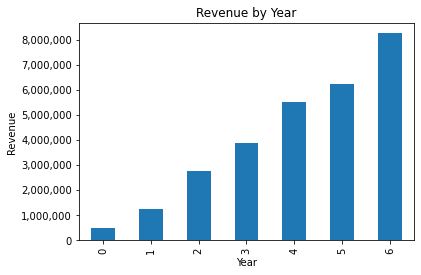

In [8]:
ax = myTable_revised.revenue_df.loc['Sum of Revenue'].plot(kind='bar', title='Revenue by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Revenue')
ax.yaxis.set_major_formatter(FuncFormatter('{0:,.0f}'.format))